In [23]:
import torch
from torch import nn
import random
from VAE_models_lightning import VAE
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns

### test removing all proteins containing non "ARNDCQEGHILKMFPSTWYV" amino acids from data (too little to learn anything meaningful from these anyways)

count    467276.000000
mean        247.695826
std         261.689224
min           1.000000
25%         112.000000
50%         203.000000
75%         316.000000
max        5070.000000
Name: residueCount, dtype: float64


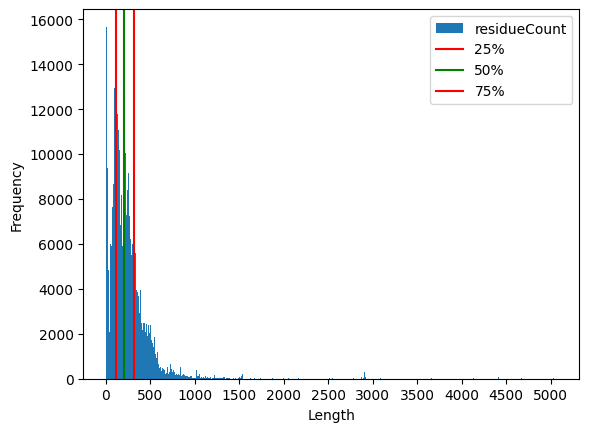

In [3]:
data = pd.read_csv("pdb_data_seq.csv")
data = data[data['sequence'].notna()]
data["residueCount"] = data["sequence"].str.len().astype(int) #fixed with this

summaryDataSet = data["residueCount"].describe()

data["residueCount"].plot.hist(bins = int(np.floor(np.sqrt(len(data)))))
plt.xticks(list(range(0, 5500, 500)))
plt.axvline(summaryDataSet.to_numpy()[4], color='red', label="25%")
plt.axvline(summaryDataSet.to_numpy()[5], color='green', label="50%")
plt.axvline(summaryDataSet.to_numpy()[6], color='red', label="75%")

plt.xlabel("Length")
plt.legend()
print(summaryDataSet)


count    313229.000000
mean        278.147515
std         157.573373
min          64.000000
25%         160.000000
50%         244.000000
75%         354.000000
max        1024.000000
Name: residueCount, dtype: float64
size dataset 313229


,index,sequence,residueCount
0,4,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154
1,7,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,165
2,8,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154
3,11,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,167
4,12,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154


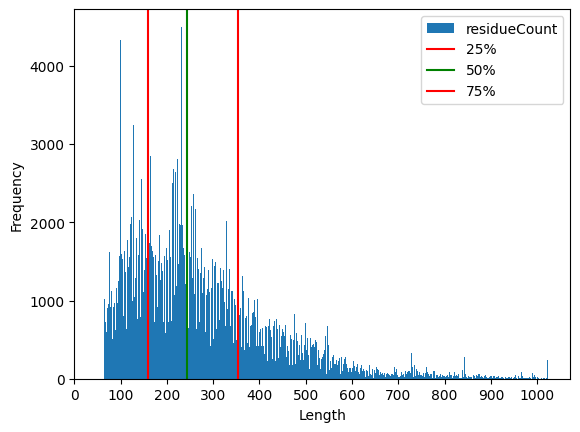

In [4]:
min_length = 64 #discard smaller than this
max_length = 1024 #+ padding
data = data.drop(data[(data["macromoleculeType"] != "Protein") |
                 (data["residueCount"] < min_length) | 
                 (data["residueCount"] > max_length)].index)

data = data.drop(["structureId", "chainId", "macromoleculeType"], axis = 1)

summaryDataSet = data["residueCount"].describe()

data["residueCount"].plot.hist(bins = int(np.floor(np.sqrt(len(data)))))
plt.xticks(list(range(0, 1050, 100)))
plt.axvline(summaryDataSet.to_numpy()[4], color='red', label="25%")
plt.axvline(summaryDataSet.to_numpy()[5], color='green', label="50%")
plt.axvline(summaryDataSet.to_numpy()[6], color='red', label="75%")

plt.xlabel("Length")
plt.legend()
print(summaryDataSet)
print("size dataset", len(data))
data = data.reset_index()
data.head()

In [5]:
#find AA containing non "ARNDCQEGHILKMFPSTWYV" all: "ARNDCEQGHILKMFPSTWYVXUZBO_#"
print("Size dataset before removing proteins containing 'XUZBO' amino acids:", len(data))
print(data["sequence"][0])
indices = []
indicesCounter = 0
for sequence in data["sequence"]:
    if any(c in sequence for c in "XUZBO"):
        indices.append(indicesCounter)
    indicesCounter += 1
print(len(indices), "samples dropped.")
data = data.drop(indices)
print(len(data))
print(data.head())
data = data.reset_index()
data.head()

Size dataset before removing proteins containing 'XUZBO' amino acids: 313229
MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRVKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG
2286 samples dropped.
310943
   index                                           sequence  residueCount
0      4  MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...           154
1      7  MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...           165
2      8  MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...           154
3     11  MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...           167
4     12  MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...           154


,level_0,index,sequence,residueCount
0,0,4,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154
1,1,7,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,165
2,2,8,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154
3,3,11,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,167
4,4,12,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154


In [6]:
# calculate the frequency of each AA
aaCount = data['sequence'].str.split('').explode().value_counts()

# convert the AA counts to a dictionary
aaFrequencies = aaCount.to_dict()
_ = aaFrequencies.pop('')
aaTotal = sum(aaFrequencies.values())

for aa in aaFrequencies.items():
    aaFrequencies[aa[0]] = aa[1]/aaTotal

# print the dictionary
print(aaFrequencies)

{'L': 0.08981822348454581, 'A': 0.08048786307383039, 'G': 0.07496656410451427, 'V': 0.06998633695913448, 'E': 0.06550577603019898, 'S': 0.06389863703727658, 'D': 0.057148574619479864, 'K': 0.0567477267020333, 'T': 0.056631386197630425, 'I': 0.05602979047872041, 'R': 0.04911075154543249, 'P': 0.04661513842906593, 'N': 0.04264146078335546, 'F': 0.039413118769937944, 'Q': 0.037721699703888605, 'Y': 0.03473043370789332, 'H': 0.027285844270572505, 'M': 0.023655382100372074, 'W': 0.013868264636283718, 'C': 0.013737027365833427}


[0.08981822348454581, 0.08048786307383039, 0.07496656410451427, 0.06998633695913448, 0.06550577603019898, 0.06389863703727658, 0.057148574619479864, 0.0567477267020333, 0.056631386197630425, 0.05602979047872041, 0.04911075154543249, 0.04661513842906593, 0.04264146078335546, 0.039413118769937944, 0.037721699703888605, 0.03473043370789332, 0.027285844270572505, 0.023655382100372074, 0.013868264636283718, 0.013737027365833427]
['L', 'A', 'G', 'V', 'E', 'S', 'D', 'K', 'T', 'I', 'R', 'P', 'N', 'F', 'Q', 'Y', 'H', 'M', 'W', 'C']


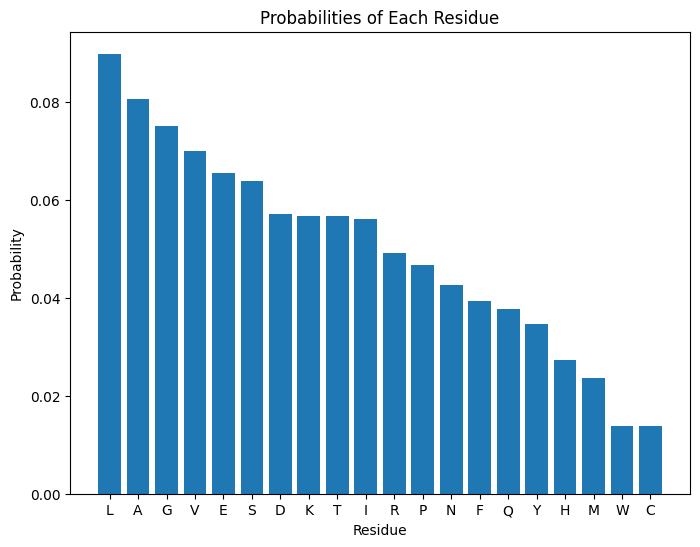

In [7]:
# Extract the probabilities of each letter into a list
probabilities_list = list(aaFrequencies.values())
print(probabilities_list)

# Extract the labels (i.e. the letters) into a list
labels = list(aaFrequencies.keys())
print(labels)

plt.figure(figsize=(8,6))

# Create the histogram using the probabilities_list
plt.bar(x=range(len(probabilities_list)), height=probabilities_list)

# Add a title and x- and y-labels
plt.title("Probabilities of Each Residue")
plt.xlabel("Residue")
plt.ylabel("Probability")

# Add the labels as tick marks on the x-axis
plt.xticks(range(len(probabilities_list)), labels)

# Show the plot
plt.show()

In [8]:
groundTruth = [] #"ARNDCEQGHILKMFPSTWYV"

AA2number = {'A' : 0, 'R': 1, 'N': 2, 'D' : 3, 'C' : 4, 'E' : 5, 'Q': 6, 
             'G' : 7, 'H' : 8, 'I' : 9, 'L' : 10, 'K' : 11, 'M': 12, 'F' : 13, 
             'P' : 14, 'S' : 15, 'T' : 16, 'W' : 17, 'Y' : 18, 'V': 19
             }

for sequence in data["sequence"]:
  testseq = np.array(list(sequence))
  groundTruth.append(np.array([AA2number[letter] for letter in np.array(list(sequence))]))

data["ground_truth"] = groundTruth

paddedSequence = []
for sequence in data["ground_truth"]:
  if len(sequence) < max_length:
    padSeq = np.full(shape = max_length - len(sequence), fill_value= 20)
    sequence = np.concatenate((sequence, padSeq), axis=None)
  paddedSequence.append(sequence)
data["ground_truth_padded"] = paddedSequence

In [9]:
def numbers_to_protein_seq(numbers):
    # create a mapping from number to amino acid
    amino_acids = "ARNDCEQGHILKMFPSTWYV#" # # = padding, find logic to remove it but currently the generated seqs are shit
    number_to_amino_acid = {i: aa for i, aa in enumerate(amino_acids)}

    # convert the sequence of numbers to a protein sequence
    seq = "".join([number_to_amino_acid[n] for n in numbers])

    return seq

# IDEAS
Visualizing the predictions and the “neuron” firings in the RNN (Karpathy blog char-RNN)
Use temperature for softmax sampling
Visualize the output activations of the last layer, show what it is mostly looking at to predict this specific position.
IF # in middle of sequence, replace randomly or sample from a distribution?
If # at the end, automatically remove all following # --> hopefully generates proteins of very different lengths


In [24]:
device = torch.device("cuda")
model = VAE().cuda()
model.load_state_dict(torch.load("VAE_protein_generator_Gaetan_v2_model_weights.pt"))

<All keys matched successfully>

In [26]:
def removePadding(sequence, numbersOfRepeatedPaddings): #search for substring
    #sequence = re.sub("#+$", "", sequence)
    pattern = r"#" * numbersOfRepeatedPaddings + "+"
    EOS = re.search(pattern, sequence)
    if EOS:
        sequence = sequence[0 : EOS.span(0)[0]]
    options = "ARNDCEQGHILKMFPSTWYV"
    sequence = sequence.replace("#", np.random.choice(np.array(list(options)), 
        p=[aaFrequencies["A"], aaFrequencies["R"], aaFrequencies["N"], aaFrequencies["D"],
        aaFrequencies["C"], aaFrequencies["E"], aaFrequencies["Q"], aaFrequencies["G"],
        aaFrequencies["H"], aaFrequencies["I"], aaFrequencies["L"], aaFrequencies["K"],
        aaFrequencies["M"], aaFrequencies["F"], aaFrequencies["P"], aaFrequencies["S"],
        aaFrequencies["T"], aaFrequencies["W"], aaFrequencies["Y"], aaFrequencies["V"]]))
    return sequence

In [27]:
sampledProteins = []
Temperature = 0.7

# generate new samples
with torch.no_grad():
    z = torch.randn(10, 128).cuda()
    output = model.decode(z)
    softmax = nn.Softmax(dim=-1)
    output_softmax = softmax(output/Temperature).double().cpu()

    count = 0
    for seq in output_softmax:
        sampledFromSoftmax = []
        for i in range(seq.shape[0]):
            normalized_probabilities = [p / torch.sum(seq[i]) for p in seq[i]]
            sampledFromSoftmax.append(np.random.choice(len(seq[i]), p=normalized_probabilities))
        sampledProteins.append(sampledFromSoftmax)
            
    output = output.max(axis = 2)[1]

print("Sampled using argmax")
lengthsArgmax = []
for sequence in output:
    seq = removePadding(numbers_to_protein_seq(sequence.tolist()), 3)
    lengthsArgmax.append(len(seq))
    print(seq, "length", len(seq))
print()
print("Sampled from softmax")
lengthsSoftmax = []
for sequence in sampledProteins:
    seq = removePadding(numbers_to_protein_seq(sequence), 3)
    lengthsSoftmax.append(len(seq))
    print(seq, "length", len(seq))


Sampled using argmax
MSSSHHHHSGLSGLGGLLLLLALALLLLLLLLLLLVLLLLLALLLLGLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLAALLLLGLLLL length 105
MSSSHHHHLGSSGLGGGLLLLALALLLLLLLLLLLVLLLALALLLLGLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLAALLLLGLLLLG length 106
MSSSHHHHSGSSGLGGGLLLLALALLLLLLLLLLLVLLLALALLLLGLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLAAALLLGMLLL length 105
MSSSHHHHLGSSGLGGLLLLLALALLLLLLLLLLLVLLLLLALLLLALLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLAALLLLGLLLL length 105
MSSSHHHHSGLSGLGGGLLLLALALLLLLLLLLLLVLLLALALLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLALLLLGLLKL length 105
MSSSHHHHSGLSGLGGGLLLLALALLLLLLLLLLLVLLLALALLLLALLLGLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLGAAALLLGLLLLGL length 107
MSSSHHHHSGSSGLGGGLLLLALALLLLLLLLLLLVLLLLLALLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLGAAALLLGLLLL length 105
MSSSHHHHSGLSGLGGGLLLLALALLLLLLLLLLEVLLLALLLLLLALLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLAALLLLGGLLLLL length 107
MSSSHHHHHGSSGLGGGLLLLALALLLLLLLLLLEVLL

In [21]:
sampledProteins = []
Temperature = 1

# generate new samples
with torch.no_grad():
    z = torch.randn(1, 128).cuda()
    output = model.decode(z)
    softmax = nn.Softmax(dim=-1)
    output_softmax = softmax(output/Temperature).double().cpu()

    softmaxProbabilitiesPerPosition = []

    count = 0
    for seq in output_softmax:
        sampledFromSoftmax = []
        for i in range(seq.shape[0]):
            normalized_probabilities = [p / torch.sum(seq[i]) for p in seq[i]]
            softmaxProbabilitiesPerPosition.append(np.array(normalized_probabilities))
            sampledFromSoftmax.append(np.random.choice(len(seq[i]), p=normalized_probabilities))
        sampledProteins.append(sampledFromSoftmax)
            
    output = output.max(axis = 2)[1]
    #print(output)

tensor([[12, 15, 15,  ..., 20, 20, 20]], device='cuda:0')


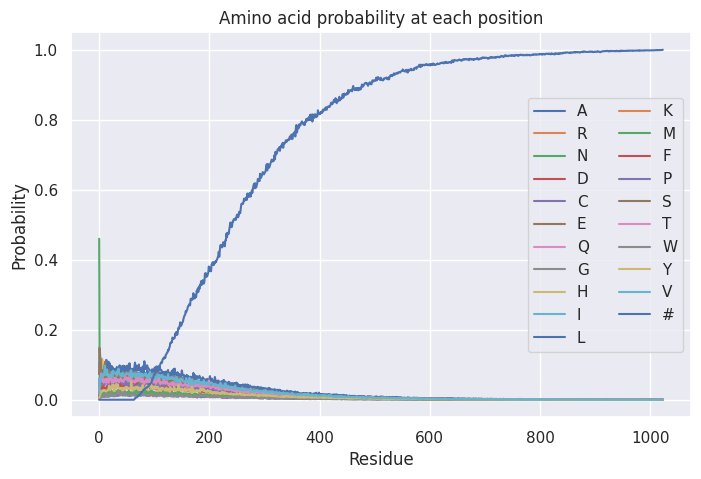

In [180]:
amino_acids = "ARNDCEQGHILKMFPSTWYV#"

fig, ax = plt.subplots(figsize=(8, 5))

for i in range(len(normalized_probabilities)):
    plt.plot(np.arange(len(softmaxProbabilitiesPerPosition)), 
        np.array(softmaxProbabilitiesPerPosition)[:, i], label=amino_acids[i])

# Add a legend to the plot
#plt.legend(ncol=7, loc='lower center', bbox_to_anchor=(0.5, -0.3))
plt.legend(ncol=2, loc="best")


# Set the x- and y-axis labels
plt.xlabel("Residue")
#plt.yticks([0.25, 0.5, 0.75, 1.])
plt.ylabel("Probability")
plt.title("Amino acid probability at each position")
#plt.yscale("log")

plt.savefig("AA probability in a single protein at every position.png")
plt.show()

# PCA/T-SNE/UMAP of protein sequences input
Make dataframe: pos 0 --> pos 1023 and then simply give it numbers from 0 to 20 and make it categorical? idk

In [67]:
columnsPos = []
for i in range(1024):
    columnsPos.append("Position " + str(i))
dfForPCA = pd.DataFrame(data["ground_truth_padded"].tolist(), columns = [columnsPos])
dfForPCA.head()

,Position 0,Position 1,Position 2,Position 3,Position 4,Position 5,Position 6,Position 7,Position 8,Position 9,...,Position 1014,Position 1015,Position 1016,Position 1017,Position 1018,Position 1019,Position 1020,Position 1021,Position 1022,Position 1023
0,12,19,10,15,5,7,5,17,6,10,...,20,20,20,20,20,20,20,20,20,20
1,12,2,9,13,5,12,10,1,9,3,...,20,20,20,20,20,20,20,20,20,20
2,12,19,10,15,5,7,5,17,6,10,...,20,20,20,20,20,20,20,20,20,20
3,12,2,9,13,5,12,10,1,9,3,...,20,20,20,20,20,20,20,20,20,20
4,12,19,10,15,5,7,5,17,6,10,...,20,20,20,20,20,20,20,20,20,20


Text(0.5, 1.0, 'PCA of 313k protein sequences')

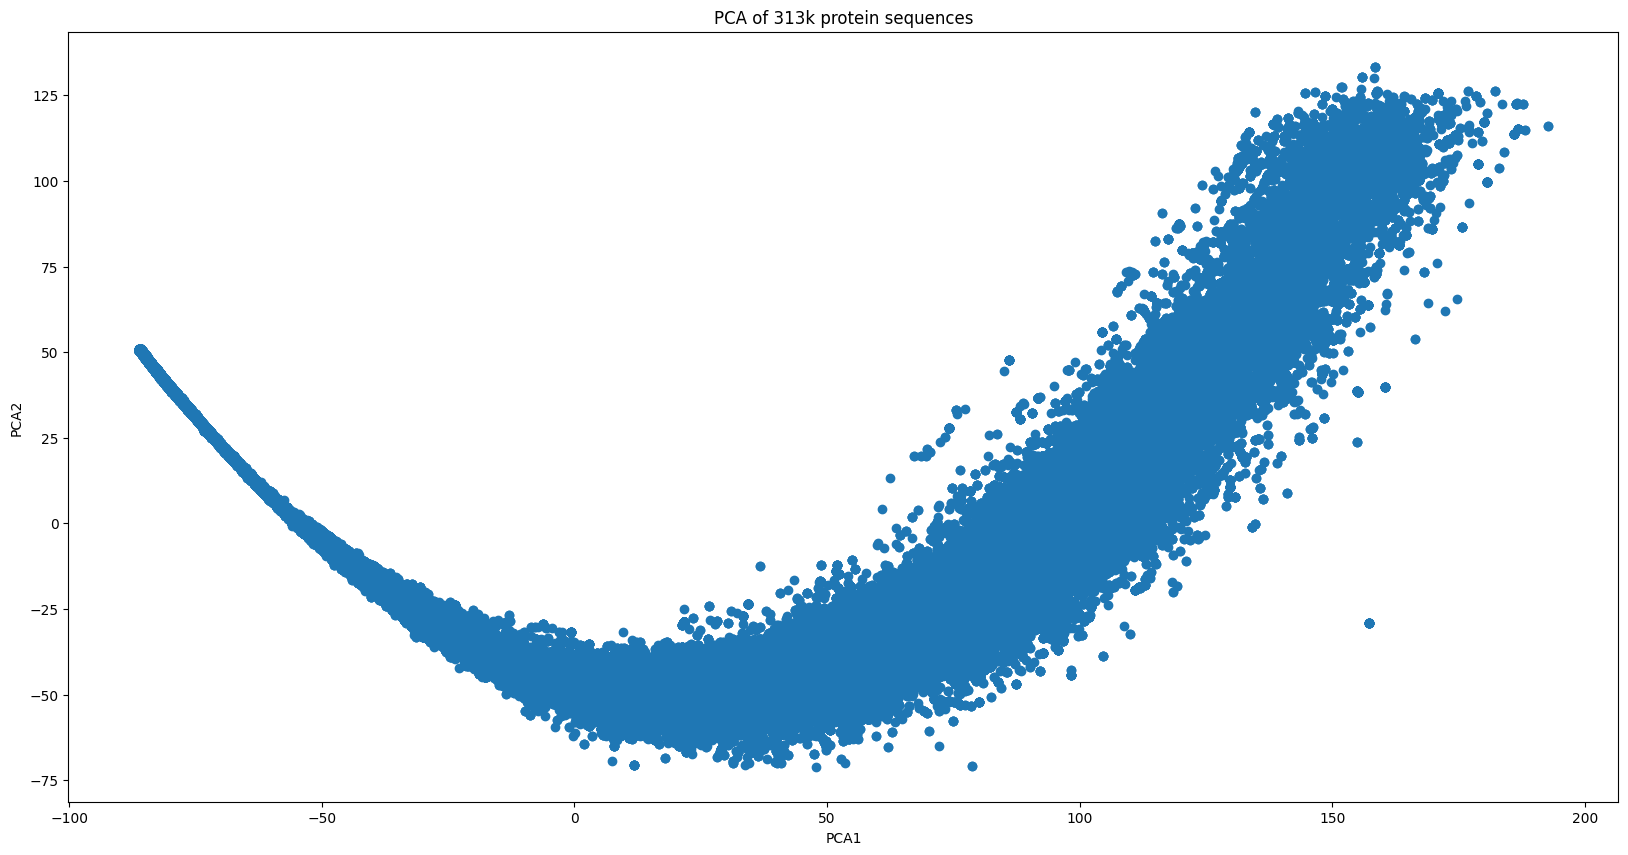

In [69]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pcaResult = pca.fit_transform(dfForPCA)

plt.figure(figsize=(20, 10))
plt.scatter(pcaResult[:, 0], pcaResult[:, 1])
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA of 313k protein sequences')


Text(0.5, 1.0, 't-SNE of 313k protein sequences')

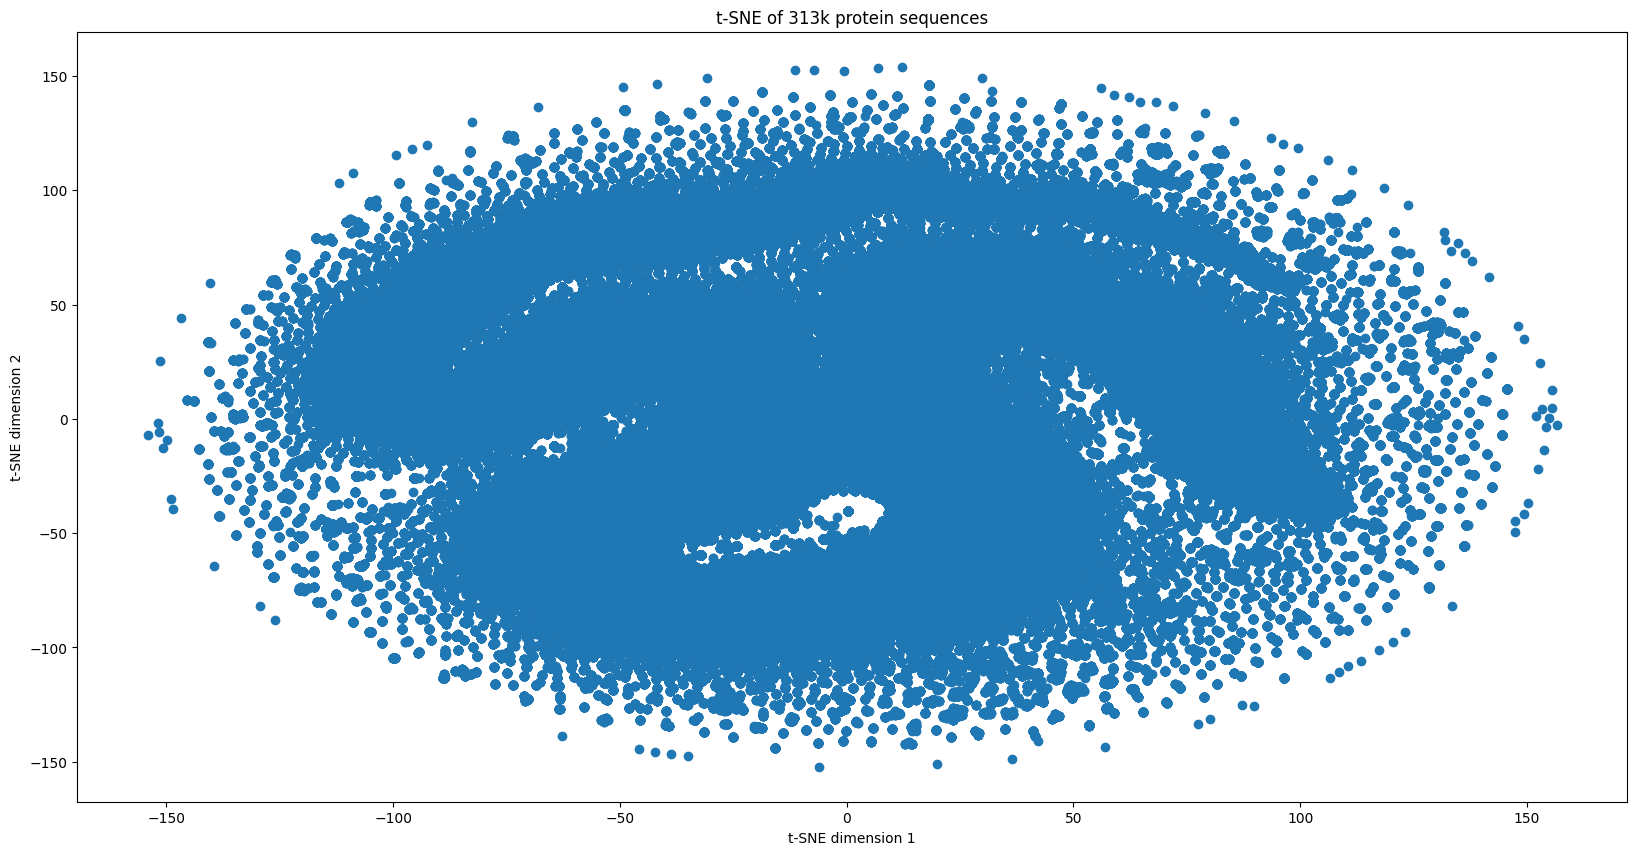

In [70]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, init='random', random_state = 1)
resultsTSNE = tsne.fit_transform(dfForPCA)

plt.figure(figsize=(20, 10))
plt.scatter(resultsTSNE[:, 0], resultsTSNE[:, 1])
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.title('t-SNE of 313k protein sequences')


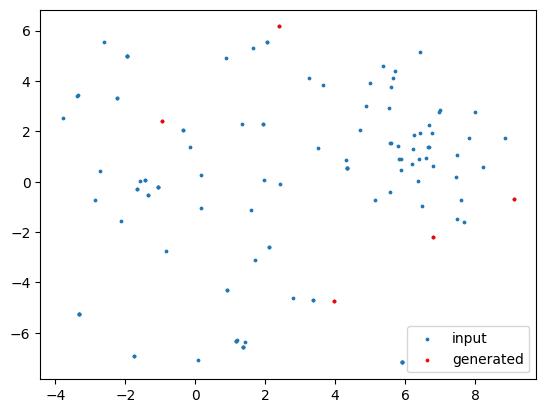

In [33]:
from sklearn.manifold import TSNE

dfForPCAtest = pd.DataFrame(data["ground_truth_padded"].head(n=100).tolist(), columns = [columnsPos])
dfToConcat = pd.DataFrame(sampledProteins, columns=[columnsPos])
dfForPCATest = pd.concat([dfForPCAtest, dfToConcat], axis=0)

tsne = TSNE(n_components = 2, init='random', random_state = 1)
resultsTSNE = tsne.fit_transform(dfForPCATest)

plt.scatter(resultsTSNE[:, 0], resultsTSNE[:, 1], s = 3, label="input")
plt.scatter(resultsTSNE[-5:, 0], resultsTSNE[-5:, 1], color="red", s=3, label="generated")
plt.legend()

# add new data points to the plot
"""new_data = [[-1, 0], [0, -1]] #add list of newly generated proteins, with padding to existing tsne plot
X_new = X + new_data
X_new_tsne = tsne.fit_transform(X_new)
plt.scatter(X_new_tsne[:, 0], X_new_tsne[:, 1])

# plot the new data points in red
plt.scatter(X_new_tsne[-2:, 0], X_new_tsne[-2:, 1], color="red")
plt.show()"""
plt.show()

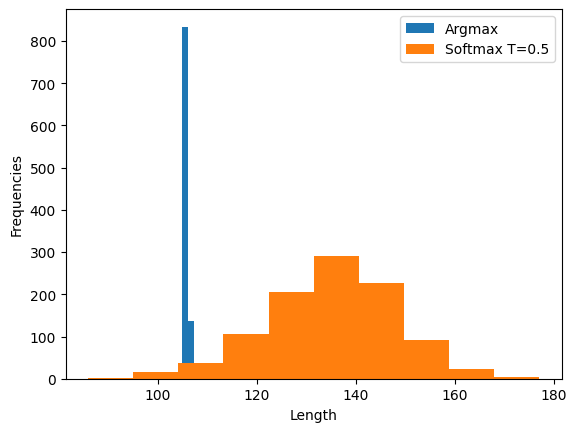

In [18]:
plt.hist(lengthsArgmax, label="Argmax"), plt.hist(lengthsSoftmax, label="Softmax T="+str(Temperature))
#plt.xticks(list(range(0, 1050, 100)))
plt.xlabel("Length")
plt.ylabel("Frequencies")
plt.legend()
plt.savefig("Distribution of sampling with T as 0_5 and removePadding3")

## make plot of probabilities for each AA at every position

In [46]:
sampledProteins = []
Temperature = 0.7

# generate new samples
with torch.no_grad():
    z = torch.randn(10, 128).cuda()
    output = model.decode(z)
    softmax = nn.Softmax(dim=-1)
    output_softmax = softmax(output/Temperature).double().cpu()

    for seq in output_softmax:
        sampledFromSoftmax = []
        for i in range(seq.shape[0]):
            normalized_probabilities = [p / torch.sum(seq[i]) for p in seq[i]]
            sampledFromSoftmax.append(np.random.choice(len(seq[i]), p=normalized_probabilities))
        sampledProteins.append(sampledFromSoftmax)
            
    output = output.max(axis = 2)[1]

generatedProteins = []
count = 1
with open('V3_VAE_generated_proteins_Gaetan.txt', 'w') as f:
    f.write("Sampled using argmax \n")
    for sequence in output:
        f.write("Protein %s \t %s \n" %(count, numbers_to_protein_seq(sequence.tolist())))
        f.flush()
        count +=1

    f.write("Sampled from softmax, using temperature = 0.5 \n")
    count = 1
    for sequence in sampledProteins:
        f.write("Protein %s \t %s \n" %(count, numbers_to_protein_seq(sequence)))
        f.flush()
        
        count += 1
print("FINISHED")

FINISHED
